<a id="0"></a> <br>
Índice
1. [Tratamiento de datos y organización de los datos.](#1)
2. [Análisis de los datos de temperatura.](#2)
3. [Modelo de predicción en la ciudad de Madrid](#3)

<a id="1"></a> <br>
### Tratamiento de datos y organización.

Primero importamos las librerias necesarias

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")


Cargamos tanto los datos tanto de las estaciones meteorologicas como los datos de clima en las diferentes estaciones.

In [8]:
df = pd.read_csv("../data/madrid/concat_clim.csv")
df_estaciones = pd.read_csv("../data/madrid/Estaciones_control_datos_meteorologicos.csv")

In [9]:
df_estaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CÓDIGO               26 non-null     int64  
 1   CÓDIGO_CORTO         26 non-null     int64  
 2   ESTACIÓN             26 non-null     object 
 3   DIRECCION            26 non-null     object 
 4   LONGITUD_ETRS89      26 non-null     object 
 5   LATITUD_ETRS89       26 non-null     object 
 6   ALTITUD              26 non-null     int64  
 7   VV (81)              10 non-null     object 
 8   DV (82)              10 non-null     object 
 9   T (83)               25 non-null     object 
 10  HR (86)              23 non-null     object 
 11  PB (87)              8 non-null      object 
 12  RS (88)              8 non-null      object 
 13  P (89)               10 non-null     object 
 14  COD_VIA              25 non-null     float64
 15  VIA_CLASE            26 non-null     objec

In [10]:
df.head(5)

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,102,VELOCIDAD VIENTO,28079102_81_98,2019,1,1,0.65,V,...,0.43,V,0.58,V,0.38,V,0.67,V,0.18,V
1,28,79,102,VELOCIDAD VIENTO,28079102_81_98,2019,1,2,0.50,V,...,0.53,V,1.13,V,2.02,V,3.48,V,2.82,V
2,28,79,102,VELOCIDAD VIENTO,28079102_81_98,2019,1,3,2.22,V,...,0.50,V,2.02,V,1.33,V,0.83,V,0.67,V
3,28,79,102,VELOCIDAD VIENTO,28079102_81_98,2019,1,4,0.87,V,...,0.13,V,0.58,V,0.92,V,0.20,V,0.33,V
4,28,79,102,VELOCIDAD VIENTO,28079102_81_98,2019,1,5,0.57,V,...,0.47,V,0.32,V,0.30,V,0.23,V,0.45,V


Hay ciertas columnas que no tienen información relevante por lo que las suprimimos.

In [11]:
df.drop(["PUNTO_MUESTREO","PROVINCIA","MUNICIPIO","V01","V02","V03","V04","V05","V06","V07","V08","V09","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24"],axis=1,inplace=True)

En cuanto a las estaciones las agrupamos según su numeración

In [12]:
df["ESTACION"]

0         102
1         102
2         102
3         102
4         102
         ... 
124498     59
124499     59
124500     59
124501     59
124502     59
Name: ESTACION, Length: 124503, dtype: int64

In [13]:
dict_est = {4:"Plaza España",8:"Escuelas Aguirre",16:"Arturo Soria",18:"Farolillo",24:"Casa de Campo",35:"Plaza del Carmen",36:"Moratalaz",38:"Cuatro Caminos",39:"Barrio del Pilar",54:"Ensanche de Vallecas",56:"Plaza Elíptica",58:"El Pardo",59:"Juan Carlos I",102:"J.M.D. Moratalaz",103:"J.M.D. Villaverde",104:"E.D.A.R. La China",106:"Centro Mpal. De Acústica",107:"J.M.D. Hortaleza",108:"Peñagrande",109:"J.M.D.Chamberí",110:"J.M.D.Centro",111:"J.M.D.Chamartin",112:"J.M.D.Vallecas 1",113:"J.M.D.Vallecas 2",114:"Matadero 01",115:"Matadero 02"}

In [14]:
df['ESTACION'] = df['ESTACION'].map(dict_est)

Obtenemos este resultado, donde vemos mucho más ordenadas las columnas con información relevante.

In [15]:
df

,ESTACION,MAGNITUD,ANO,MES,DIA,H01,H02,H03,H04,H05,...,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24
0,J.M.D. Moratalaz,VELOCIDAD VIENTO,2019,1,1,0.65,0.95,0.87,0.73,0.57,...,0.77,0.35,0.98,0.47,0.37,0.43,0.58,0.38,0.67,0.18
1,J.M.D. Moratalaz,VELOCIDAD VIENTO,2019,1,2,0.50,0.95,0.60,0.73,1.62,...,0.52,0.50,0.57,0.80,0.88,0.53,1.13,2.02,3.48,2.82
2,J.M.D. Moratalaz,VELOCIDAD VIENTO,2019,1,3,2.22,2.53,2.20,2.43,1.90,...,0.82,1.12,0.77,0.43,0.25,0.50,2.02,1.33,0.83,0.67
3,J.M.D. Moratalaz,VELOCIDAD VIENTO,2019,1,4,0.87,0.77,0.87,0.92,0.65,...,0.48,0.28,0.68,0.47,0.40,0.13,0.58,0.92,0.20,0.33
4,J.M.D. Moratalaz,VELOCIDAD VIENTO,2019,1,5,0.57,1.82,1.65,0.55,0.58,...,0.68,0.87,0.60,0.45,0.60,0.47,0.32,0.30,0.23,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124498,Juan Carlos I,PRECIPITACIÓN,2022,12,27,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
124499,Juan Carlos I,PRECIPITACIÓN,2022,12,28,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
124500,Juan Carlos I,PRECIPITACIÓN,2022,12,29,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
124501,Juan Carlos I,PRECIPITACIÓN,2022,12,30,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


En cuanto a magnitudes tenemos todas estas pero solo vamos a fijarnos en las temperaturas de cada estación por tanto lo aplicamos.

In [16]:
df["MAGNITUD"].unique()

array(['VELOCIDAD VIENTO', 'DIR. DE VIENTO', 'TEMPERATURA',
       'HUMEDAD RELATIVA', 'PRESION BARIOMETRICA', 'RADIACION SOLAR',
       'PRECIPITACIÓN', '80'], dtype=object)

In [17]:
df_temperatura = df.loc[df['MAGNITUD'] == 'TEMPERATURA']

In [18]:
df_temperatura

,ESTACION,MAGNITUD,ANO,MES,DIA,H01,H02,H03,H04,H05,...,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24
62,J.M.D. Moratalaz,TEMPERATURA,2019,1,1,3.1,2.9,3.1,1.9,0.7,...,10.4,11.9,10.1,8.5,7.7,7.1,6.6,5.8,4.1,3.4
63,J.M.D. Moratalaz,TEMPERATURA,2019,1,2,2.3,1.8,0.9,-0.2,-1.1,...,10.6,11.7,11.5,9.9,8.7,8.2,7.4,5.4,4.6,3.9
64,J.M.D. Moratalaz,TEMPERATURA,2019,1,3,3.0,2.8,2.0,2.0,1.6,...,9.9,9.7,9.7,8.6,8.1,7.4,6.0,4.6,3.9,3.4
65,J.M.D. Moratalaz,TEMPERATURA,2019,1,4,2.1,1.5,1.0,0.7,0.1,...,10.9,11.7,10.5,8.8,6.9,6.2,5.7,4.7,4.1,3.4
66,J.M.D. Moratalaz,TEMPERATURA,2019,1,5,1.8,0.1,-0.6,-0.4,-0.3,...,9.5,10.6,10.7,9.1,7.1,6.3,5.7,4.1,4.2,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124374,Juan Carlos I,TEMPERATURA,2022,12,27,7.2,6.5,6.0,5.5,5.0,...,14.2,14.9,15.0,13.7,11.0,10.1,10.0,8.5,7.5,6.6
124375,Juan Carlos I,TEMPERATURA,2022,12,28,5.7,5.6,5.1,4.7,4.3,...,13.4,13.2,13.5,12.5,11.8,11.1,10.8,10.3,10.3,10.5
124376,Juan Carlos I,TEMPERATURA,2022,12,29,10.1,9.5,9.1,8.5,8.5,...,11.4,11.4,11.3,11.5,11.2,11.0,10.9,10.4,11.0,11.1
124377,Juan Carlos I,TEMPERATURA,2022,12,30,11.2,11.3,11.0,11.0,10.9,...,13.0,12.9,12.5,12.3,11.6,11.3,11.0,10.0,9.7,8.4


Ahora sacamos un df para cada estación.

In [19]:
df_temperatura_plz_esp = df_temperatura.loc[df_temperatura['ESTACION'] == "Plaza España"]
df_temperatura_esc_agu = df_temperatura.loc[df_temperatura['ESTACION'] == 'Escuelas Aguirre']
df_temperatura_art_soria = df_temperatura.loc[df_temperatura['ESTACION'] == "Arturo Soria"]
df_temperatura_farolillo = df_temperatura.loc[df_temperatura['ESTACION'] == "Farolillo"]
df_temperatura_casa_campo = df_temperatura.loc[df_temperatura['ESTACION'] == "Casa de Campo"]
df_temperatura_plaza_carmen = df_temperatura.loc[df_temperatura['ESTACION'] == "Plaza del Carmen"]
df_temperatura_moratalaz = df_temperatura.loc[df_temperatura['ESTACION'] == "Moratalaz"]
df_temperatura_cuatro_caminos = df_temperatura.loc[df_temperatura['ESTACION'] == "Cuatro Caminos"]
df_temperatura_barrio_pilar = df_temperatura.loc[df_temperatura['ESTACION'] == "Barrio del Pilar"]
df_temperatura_ensanche_vall = df_temperatura.loc[df_temperatura['ESTACION'] == "Ensanche de Vallecas"]
df_temperatura_plaza_elip = df_temperatura.loc[df_temperatura['ESTACION'] == "Plaza Elíptica"]
df_temperatura_pardo = df_temperatura.loc[df_temperatura['ESTACION'] == "El Pardo"]
df_temperatura_jcprimero = df_temperatura.loc[df_temperatura['ESTACION'] == "Juan Carlos I"]
df_temperatura_moratalaz = df_temperatura.loc[df_temperatura['ESTACION'] == "J.M.D. Moratalaz"]
df_temperatura_villaverde = df_temperatura.loc[df_temperatura['ESTACION'] == "J.M.D. Villaverde"]
df_temperatura_china = df_temperatura.loc[df_temperatura['ESTACION'] == "E.D.A.R. La China"]
df_temperatura_acustica = df_temperatura.loc[df_temperatura['ESTACION'] == "Centro Mpal. De Acústica"]
df_temperatura_hortaleza = df_temperatura.loc[df_temperatura['ESTACION'] == "J.M.D. Hortaleza"]
df_temperatura_penagrande = df_temperatura.loc[df_temperatura['ESTACION'] == "Peñagrande"]
df_temperatura_chamberi = df_temperatura.loc[df_temperatura['ESTACION'] == "J.M.D.Chamberí"]
df_temperatura_centro = df_temperatura.loc[df_temperatura['ESTACION'] == "J.M.D.Centro"]
df_temperatura_chamartin = df_temperatura.loc[df_temperatura['ESTACION'] == "J.M.D.Chamartin"]
df_temperatura_vallecas_1 = df_temperatura.loc[df_temperatura['ESTACION'] == "J.M.D.Vallecas 1"]
df_temperatura_vallecas_2 = df_temperatura.loc[df_temperatura['ESTACION'] == "J.M.D.Vallecas 2"]
df_temperatura_matadero_1 = df_temperatura.loc[df_temperatura['ESTACION'] == "Matadero 01"]
df_temperatura_matadero_2 = df_temperatura.loc[df_temperatura['ESTACION'] == "Matadero 02"]


In [20]:
df_temperatura_plz_esp.reset_index(drop=True, inplace=True)
df_temperatura_esc_agu.reset_index(drop=True, inplace=True)
df_temperatura_art_soria.reset_index(drop=True, inplace=True)
df_temperatura_farolillo.reset_index(drop=True, inplace=True)
df_temperatura_casa_campo.reset_index(drop=True, inplace=True)
df_temperatura_plaza_carmen.reset_index(drop=True, inplace=True)
df_temperatura_moratalaz.reset_index(drop=True, inplace=True)
df_temperatura_cuatro_caminos.reset_index(drop=True, inplace=True)
df_temperatura_barrio_pilar.reset_index(drop=True, inplace=True)
df_temperatura_ensanche_vall.reset_index(drop=True, inplace=True)
df_temperatura_plaza_elip.reset_index(drop=True, inplace=True)
df_temperatura_pardo.reset_index(drop=True, inplace=True)
df_temperatura_jcprimero.reset_index(drop=True, inplace=True)
df_temperatura_moratalaz.reset_index(drop=True, inplace=True)
df_temperatura_villaverde.reset_index(drop=True, inplace=True)
df_temperatura_china.reset_index(drop=True, inplace=True)
df_temperatura_acustica.reset_index(drop=True, inplace=True)
df_temperatura_hortaleza.reset_index(drop=True, inplace=True)
df_temperatura_penagrande.reset_index(drop=True, inplace=True)
df_temperatura_chamberi.reset_index(drop=True, inplace=True)
df_temperatura_centro.reset_index(drop=True, inplace=True)
df_temperatura_chamartin.reset_index(drop=True, inplace=True)
df_temperatura_vallecas_1.reset_index(drop=True, inplace=True)
df_temperatura_vallecas_2.reset_index(drop=True, inplace=True)
df_temperatura_matadero_1.reset_index(drop=True, inplace=True)
df_temperatura_matadero_2.reset_index(drop=True, inplace=True)



In [21]:
df_temperatura_plz_esp

,ESTACION,MAGNITUD,ANO,MES,DIA,H01,H02,H03,H04,H05,...,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24
0,Plaza España,TEMPERATURA,2019,1,1,1.1,0.4,-0.1,-0.5,-0.9,...,13.8,15.8,15.7,12.9,10.1,8.6,6.0,3.7,2.3,1.0
1,Plaza España,TEMPERATURA,2019,1,2,0.7,-0.2,-0.9,-1.1,-2.0,...,13.4,15.3,17.0,13.2,10.6,8.3,4.9,3.6,2.6,0.6
2,Plaza España,TEMPERATURA,2019,1,3,0.0,0.1,-0.8,-0.9,-1.3,...,13.4,14.5,14.3,12.4,10.5,8.0,5.4,3.6,2.6,1.5
3,Plaza España,TEMPERATURA,2019,1,4,0.7,-0.1,-0.7,-1.0,-1.3,...,13.2,15.0,15.5,13.1,10.5,8.5,5.6,2.8,2.1,0.6
4,Plaza España,TEMPERATURA,2019,1,5,-0.1,-0.6,-1.4,-1.9,-2.3,...,12.6,14.4,16.3,13.1,10.3,8.3,5.2,3.2,2.1,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,Plaza España,TEMPERATURA,2022,12,27,6.2,5.5,4.7,4.3,4.0,...,17.4,18.7,17.8,15.3,14.6,12.7,10.0,8.2,6.9,6.1
1205,Plaza España,TEMPERATURA,2022,12,28,5.2,4.8,4.3,3.4,3.0,...,16.5,17.5,16.3,14.1,12.9,12.2,11.6,10.7,10.9,10.6
1206,Plaza España,TEMPERATURA,2022,12,29,11.1,10.9,10.3,9.7,9.6,...,11.5,11.8,12.1,12.1,11.8,11.8,11.7,11.4,11.7,11.8
1207,Plaza España,TEMPERATURA,2022,12,30,11.9,11.9,11.5,11.5,11.5,...,13.7,13.6,13.6,13.0,12.4,12.2,11.8,11.4,11.1,10.6


In [22]:
df_temperatura_plz_esp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 29 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ESTACION  1209 non-null   object 
 1   MAGNITUD  1209 non-null   object 
 2   ANO       1209 non-null   int64  
 3   MES       1209 non-null   int64  
 4   DIA       1209 non-null   int64  
 5   H01       1209 non-null   float64
 6   H02       1209 non-null   float64
 7   H03       1209 non-null   float64
 8   H04       1209 non-null   float64
 9   H05       1209 non-null   float64
 10  H06       1209 non-null   float64
 11  H07       1209 non-null   float64
 12  H08       1209 non-null   float64
 13  H09       1209 non-null   float64
 14  H10       1209 non-null   float64
 15  H11       1209 non-null   float64
 16  H12       1209 non-null   float64
 17  H13       1209 non-null   float64
 18  H14       1209 non-null   float64
 19  H15       1209 non-null   float64
 20  H16       1209 non-null   floa

Conversión a datetime de todas las columnas solo dejando la columna de temperatura para poder funcionar con ella

In [23]:
# Funciones para poder poner todos los df con la misma estructura
def format_fecha(row):
    try:
        fecha_str = f"{row['ANO']}-{row['MES']:02d}-{row['DIA']:02d}-{int(row['HORA'][1:]):02d}"
        if row['HORA'] == 'H24':
            # Verificar si el día es el último día del mes
            ultimo_dia_del_mes = calendar.monthrange(row['ANO'], row['MES'])[1]
            if row['DIA'] == ultimo_dia_del_mes:
                fecha_str = f"{row['ANO']}-{row['MES']:02d}-{row['DIA']:02d}-00"
            else:
                fecha_str = f"{row['ANO']}-{row['MES']:02d}-{row['DIA']+1:02d}-00"
        return pd.to_datetime(fecha_str, format='%Y-%m-%d-%H')
    except ValueError:
        return pd.NaT

def procesar_temperaturas(df):
    columnas_horas = [f'H{i:02}' for i in range(1, 25)]

    data_melted = pd.melt(df, id_vars=['ESTACION', 'MAGNITUD', 'ANO', 'MES', 'DIA'], value_vars=columnas_horas, var_name='HORA', value_name='TEMPERATURA')
    data_melted['Fecha'] = data_melted.apply(format_fecha, axis=1)
    data_melted = data_melted.drop(columns=['ANO', 'MES', 'DIA', 'HORA'])
    data_melted = data_melted.sort_values(by='Fecha')
    data_melted = data_melted.rename(columns={'Fecha': 'FECHA'})
    cols = data_melted.columns.tolist()
    cols = ['FECHA'] + [col for col in cols if col != 'FECHA']
    data_melted = data_melted[cols]
    data_melted.loc[data_melted['TEMPERATURA'] < -20, 'TEMPERATURA'] = 0

    return data_melted

In [24]:
df_plz_esp = procesar_temperaturas(df_temperatura_plz_esp)
df_esc_agu = procesar_temperaturas(df_temperatura_esc_agu)
df_art_soria = procesar_temperaturas(df_temperatura_art_soria)
df_farolillo = procesar_temperaturas(df_temperatura_farolillo)
df_casa_campo = procesar_temperaturas(df_temperatura_casa_campo)
df_plaza_carmen = procesar_temperaturas(df_temperatura_plaza_carmen)
df_moratalaz = procesar_temperaturas(df_temperatura_moratalaz)
df_cuatro_caminos = procesar_temperaturas(df_temperatura_cuatro_caminos)
df_barrio_pilar = procesar_temperaturas(df_temperatura_barrio_pilar)
df_ensanche_vall = procesar_temperaturas(df_temperatura_ensanche_vall)
df_plaza_elip = procesar_temperaturas(df_temperatura_plaza_elip)
df_pardo = procesar_temperaturas(df_temperatura_pardo)
df_jcprimero = procesar_temperaturas(df_temperatura_jcprimero)
df_moratalaz = procesar_temperaturas(df_temperatura_moratalaz)
df_villaverde = procesar_temperaturas(df_temperatura_villaverde)
df_china = procesar_temperaturas(df_temperatura_china)
df_acustica = procesar_temperaturas(df_temperatura_acustica)
df_hortaleza = procesar_temperaturas(df_temperatura_hortaleza)
df_penagrande = procesar_temperaturas(df_temperatura_penagrande)
df_chamberi = procesar_temperaturas(df_temperatura_chamberi)
df_centro = procesar_temperaturas(df_temperatura_centro)
df_chamartin = procesar_temperaturas(df_temperatura_chamartin)
df_plz_esp = procesar_temperaturas(df_temperatura_plz_esp)
df_vallecas_1 = procesar_temperaturas(df_temperatura_vallecas_1)
df_vallecas_2 = procesar_temperaturas(df_temperatura_vallecas_2)
df_matadero_1 = procesar_temperaturas(df_temperatura_matadero_1)
df_matadero_2 = procesar_temperaturas(df_temperatura_matadero_2)

In [25]:
df_plz_esp.to_csv("../data/temp_ok/plz_esp.csv", index=False)
df_esc_agu.to_csv("../data/temp_ok/esc_agu.csv", index=False)
df_art_soria.to_csv("../data/temp_ok/art_soria.csv", index=False)
df_farolillo.to_csv("../data/temp_ok/farolillo.csv", index=False)
df_casa_campo.to_csv("../data/temp_ok/casa_campo.csv", index=False)
df_plaza_carmen.to_csv("../data/temp_ok/plaza_carmen.csv", index=False)
df_moratalaz.to_csv("../data/temp_ok/moratalaz.csv", index=False)
df_cuatro_caminos.to_csv("../data/temp_ok/cuatro_caminos.csv", index=False)
df_barrio_pilar.to_csv("../data/temp_ok/barrio_pilar.csv", index=False)
df_ensanche_vall.to_csv("../data/temp_ok/ensanche_vall.csv", index=False)
df_plaza_elip.to_csv("../data/temp_ok/plaza_elip.csv", index=False)
df_pardo.to_csv("../data/temp_ok/pardo.csv", index=False)
df_jcprimero.to_csv("../data/temp_ok/jcprimero.csv", index=False)
df_moratalaz.to_csv("../data/temp_ok/moratalaz.csv", index=False)
df_villaverde.to_csv("../data/temp_ok/villaverde.csv", index=False)
df_china.to_csv("../data/temp_ok/china.csv", index=False)
df_acustica.to_csv("../data/temp_ok/acustica.csv", index=False)
df_hortaleza.to_csv("../data/temp_ok/hortalez.csv", index=False)
df_penagrande.to_csv("../data/temp_ok/penagrande.csv", index=False)
df_chamberi.to_csv("../data/temp_ok/chamberi.csv", index=False)
df_centro.to_csv("../data/temp_ok/centro.csv", index=False)
df_chamartin.to_csv("../data/temp_ok/chamartin.csv", index=False)
df_vallecas_1.to_csv("../data/temp_ok/vallecas_1.csv", index=False)
df_vallecas_2.to_csv("../data/temp_ok/vallecas_2.csv", index=False)
df_matadero_1.to_csv("../data/temp_ok/matadero_1.csv", index=False)
df_matadero_2.to_csv("../data/temp_ok/matadero_2.csv", index=False)

[Volver al índice](#0)

De todas las estaciones las que tienen mas sentido para hacer un modelo de machine learning serian la estacion de farolillo y plaza de españa

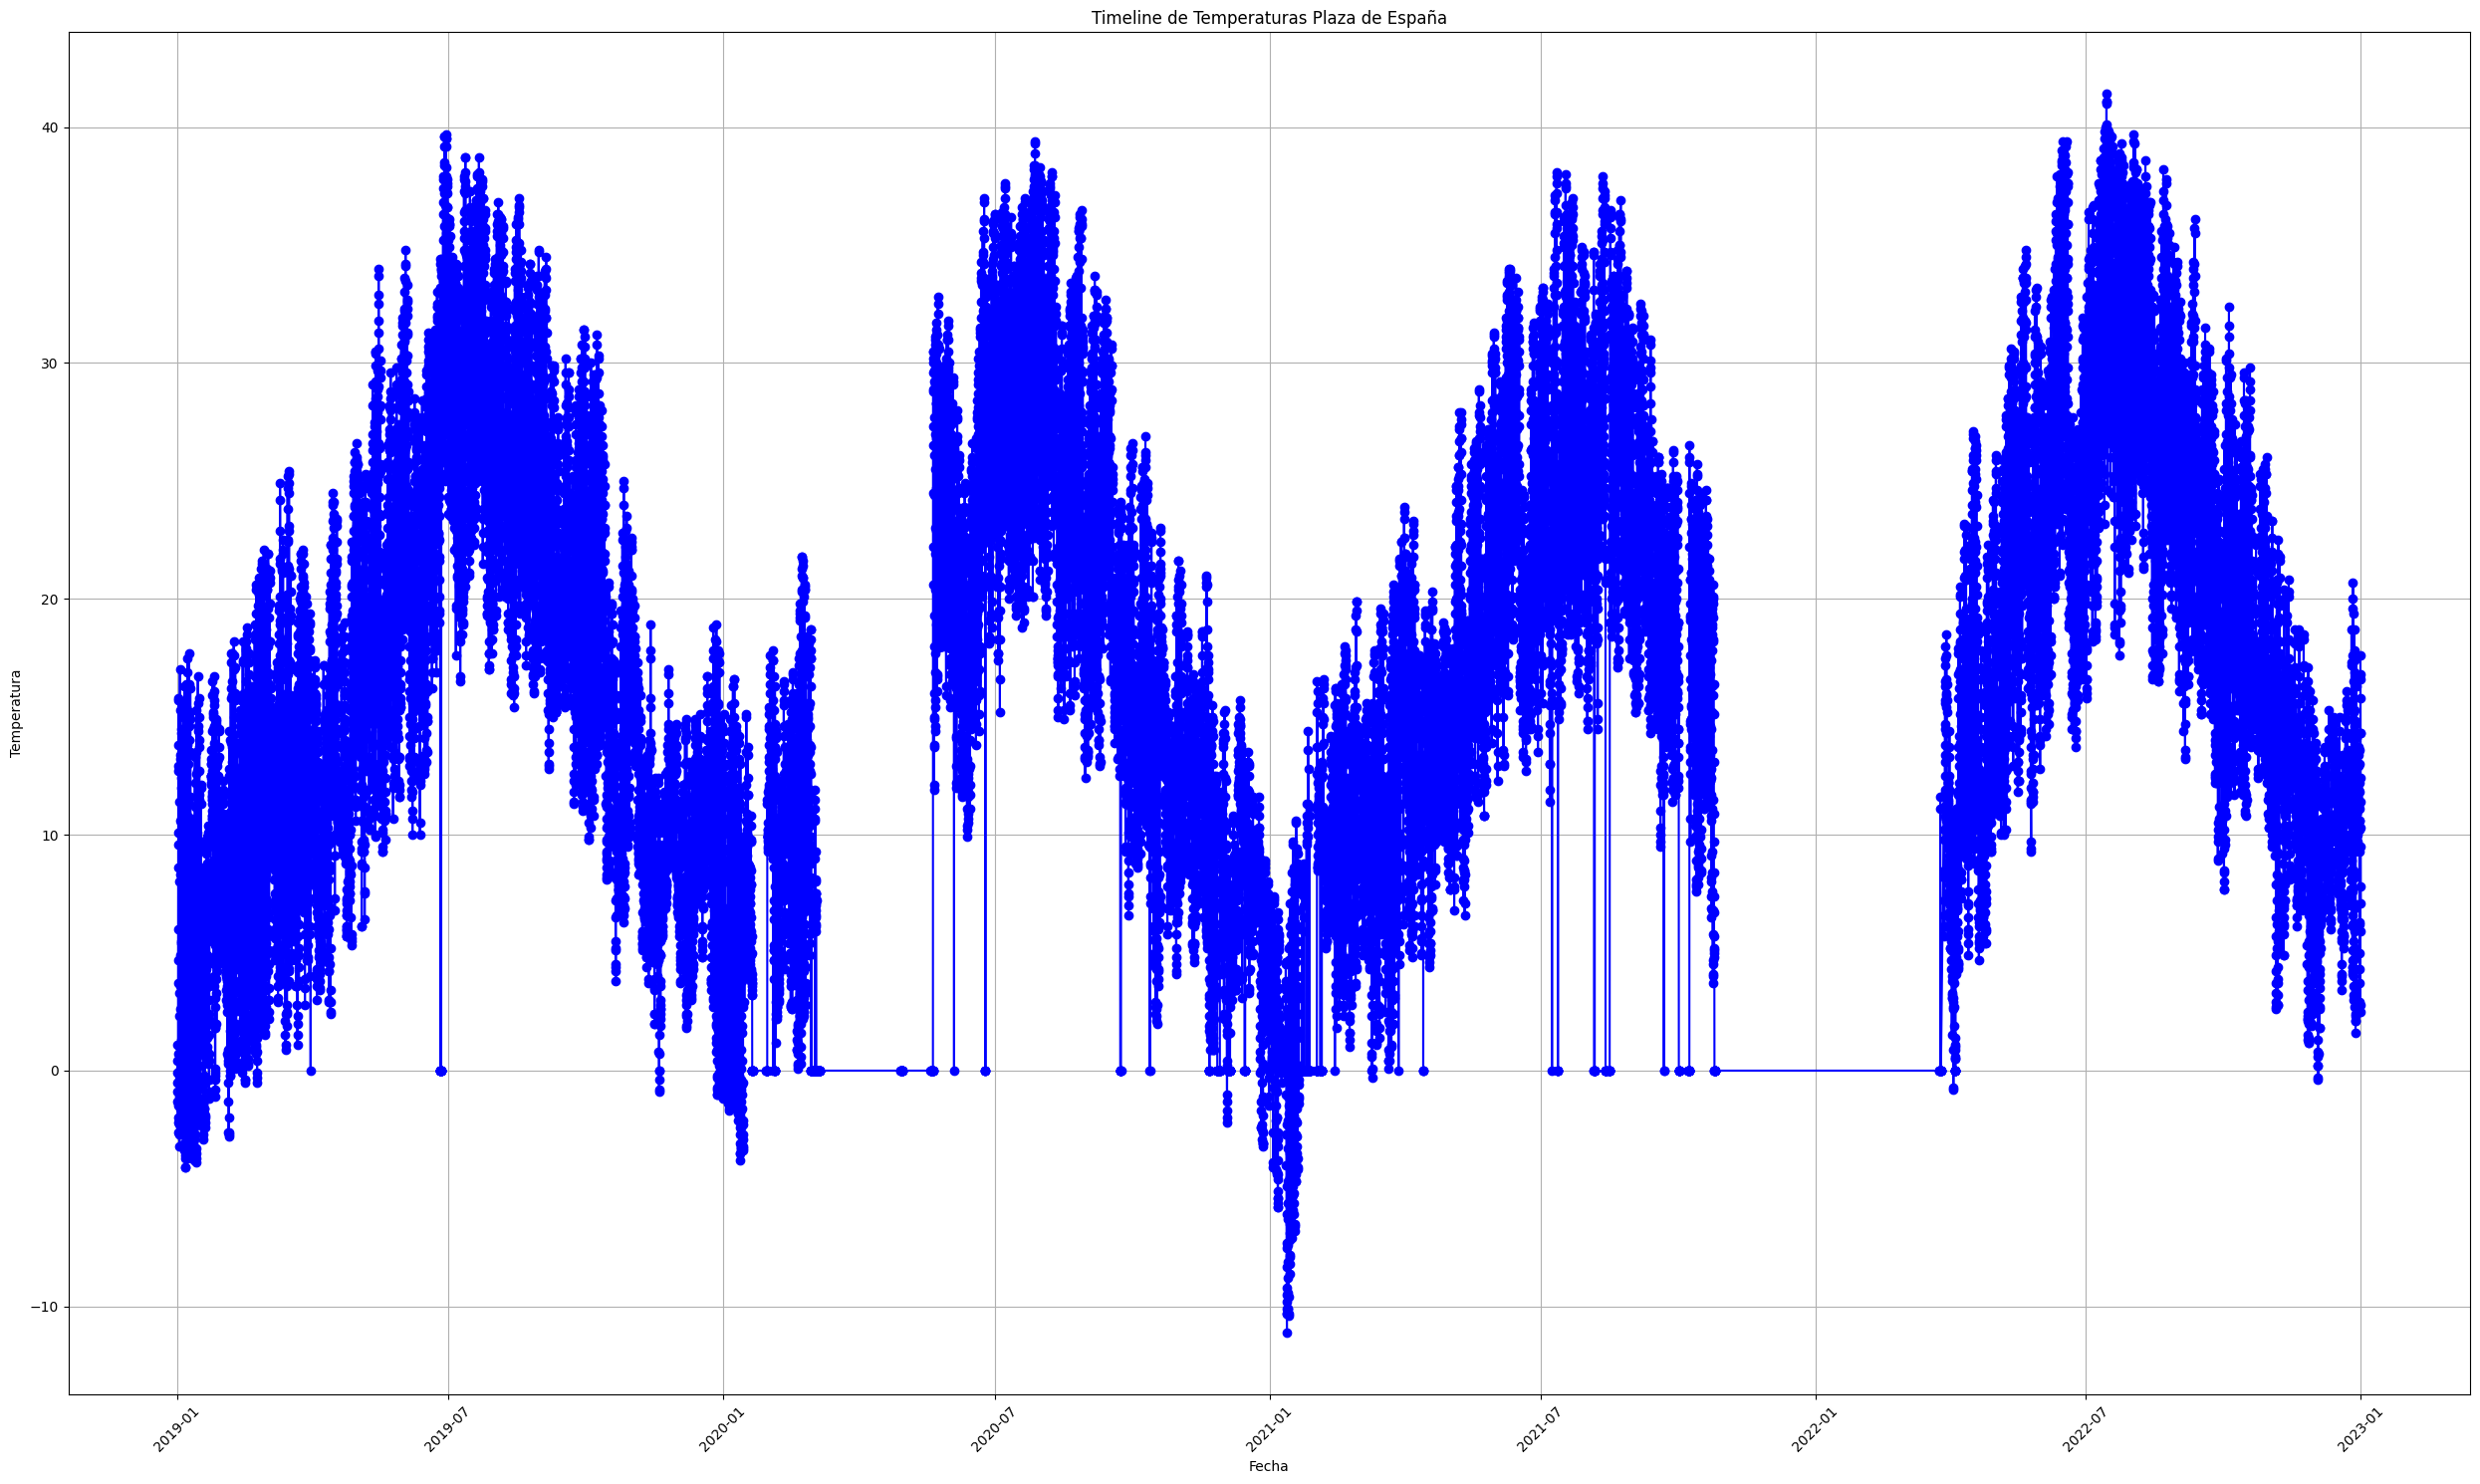

In [50]:
plt.figure(figsize=(25, 15))
plt.plot(df_plz_esp['FECHA'], df_plz_esp['TEMPERATURA'], marker='o', linestyle='-', color='b')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title('Timeline de Temperaturas Plaza de España')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

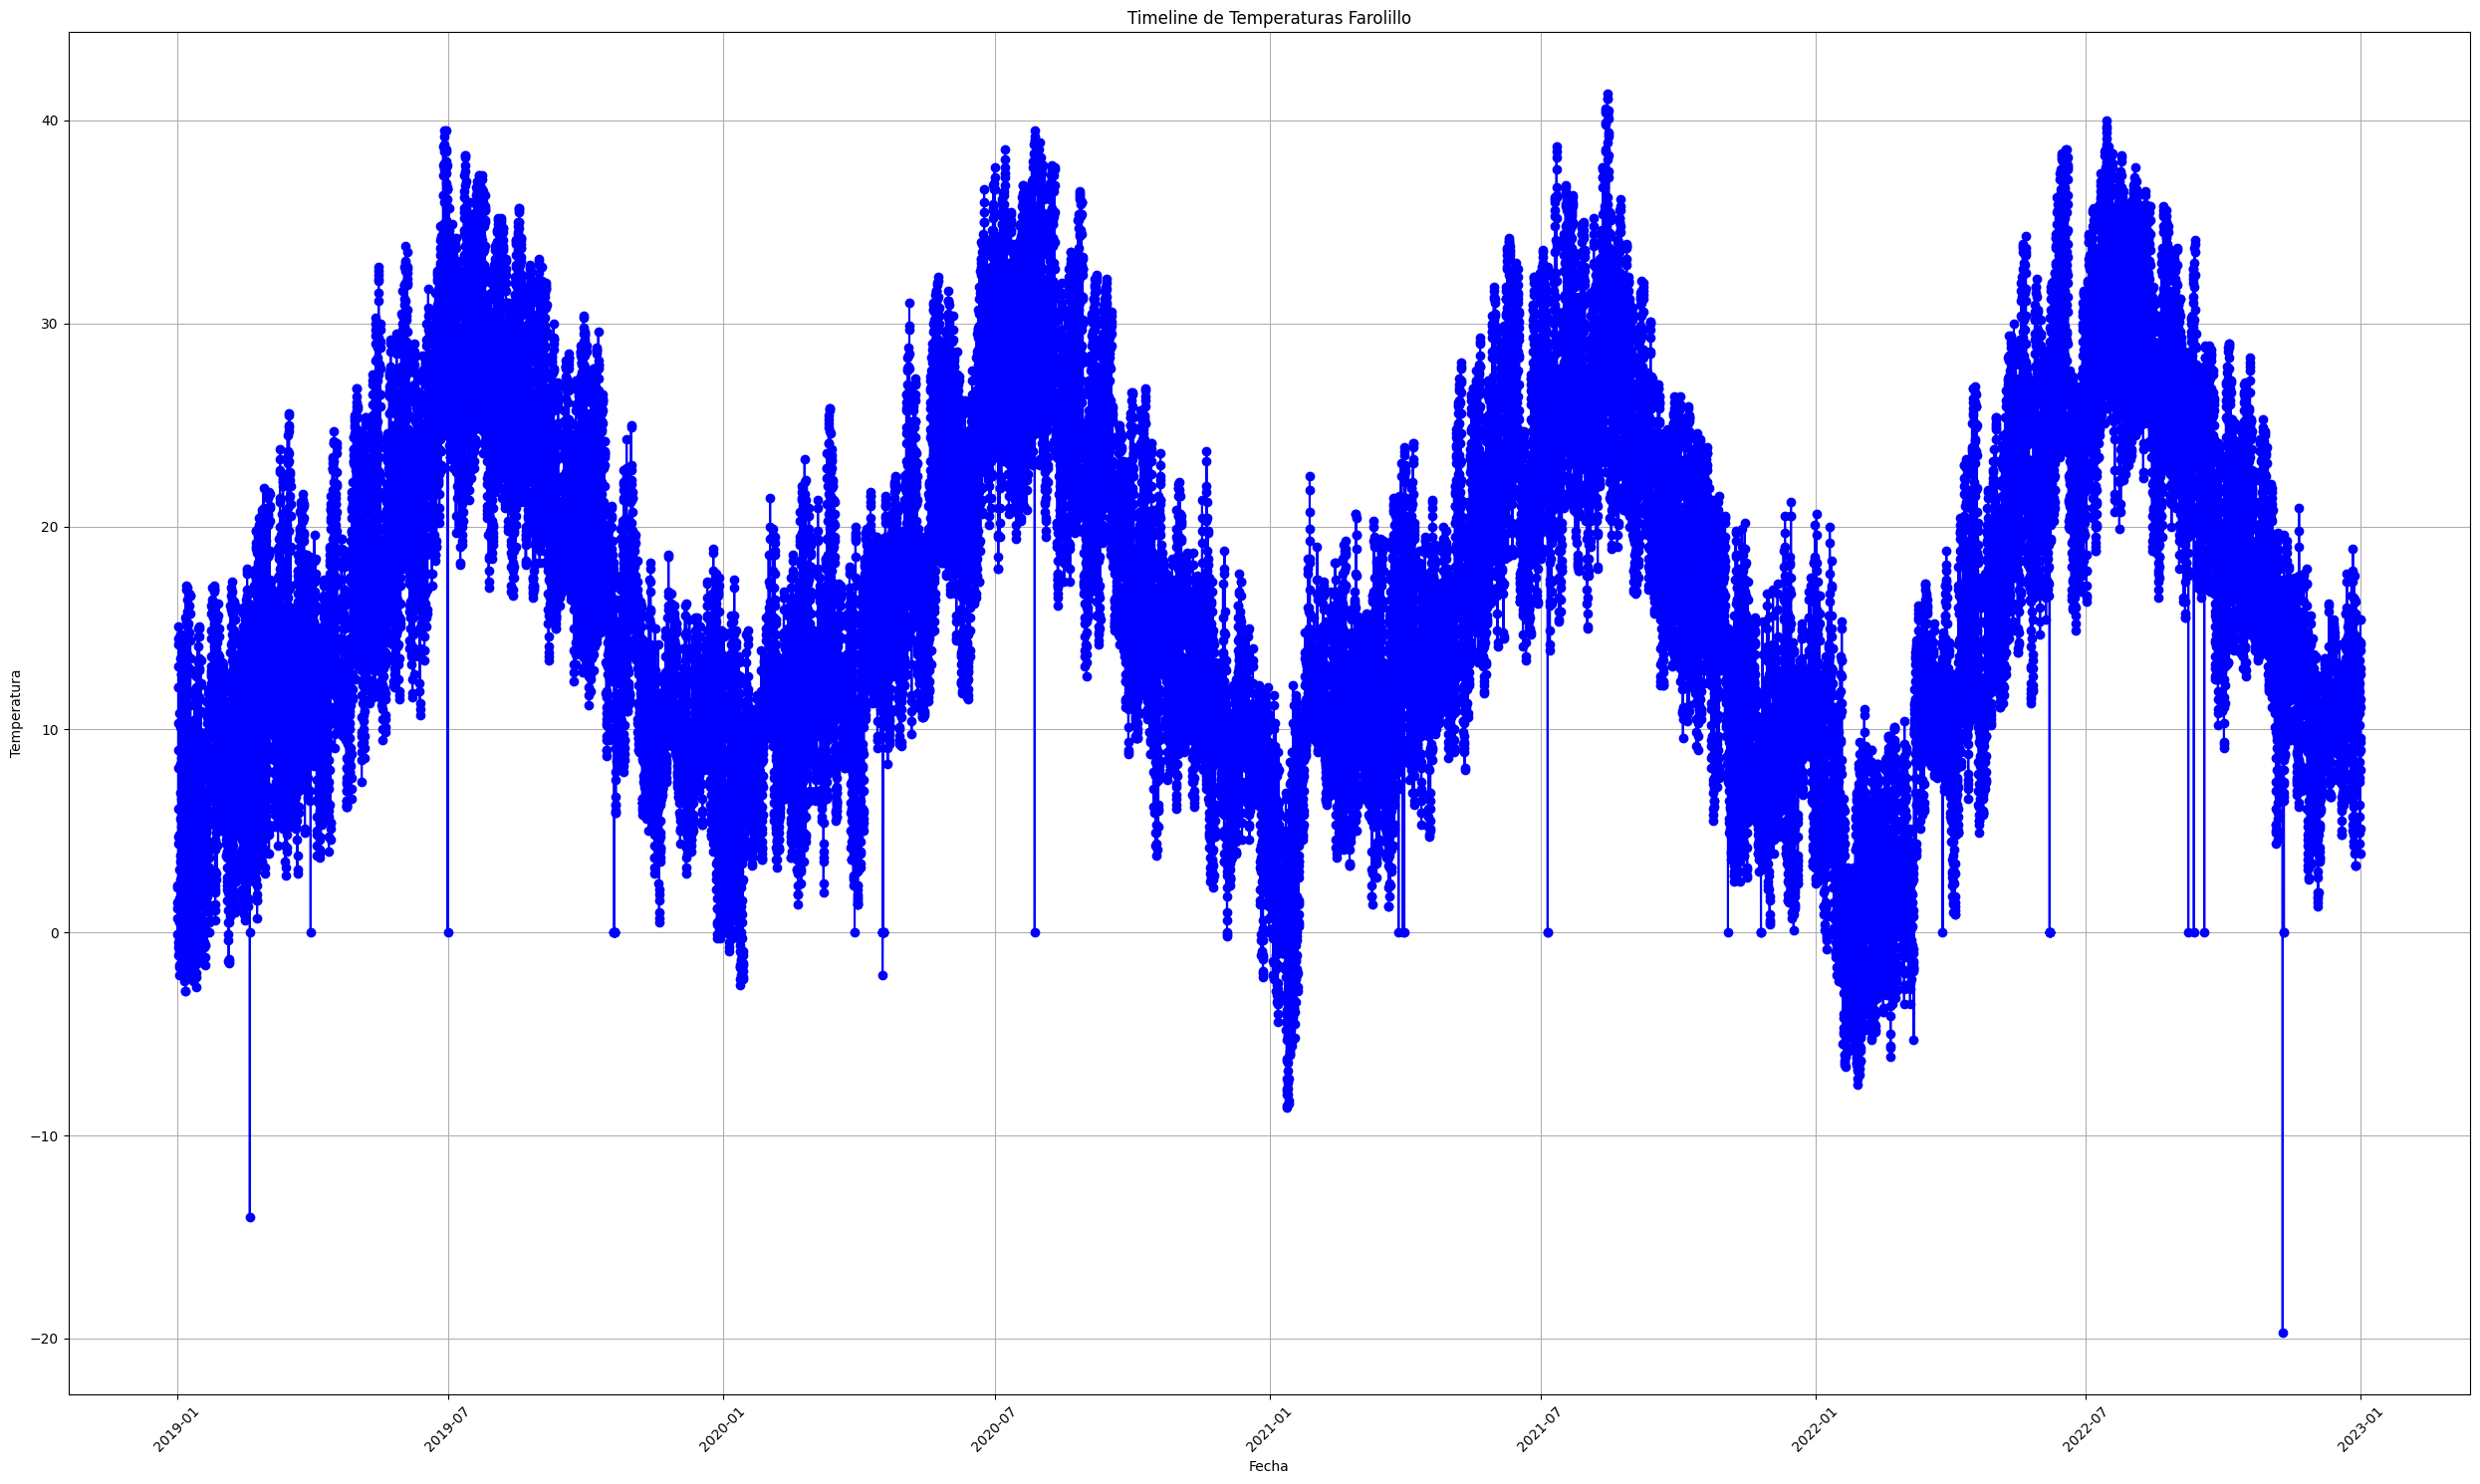

In [27]:
plt.figure(figsize=(25, 15))
plt.plot(df_farolillo['FECHA'], df_farolillo['TEMPERATURA'], marker='o', linestyle='-', color='b')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title('Timeline de Temperaturas Farolillo')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [3]:
df_farolillo = pd.read_csv("../data/temp_ok/farolillo.csv")

In [4]:
df_farolillo['FECHA'] = pd.to_datetime(df_farolillo['FECHA'])

In [5]:
df_farolillo.drop(columns=['ESTACION','MAGNITUD'], inplace=True)

In [6]:
df_farolillo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   FECHA        35064 non-null  datetime64[ns]
 1   TEMPERATURA  35064 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 548.0 KB


Intentamos quitar outliners del DF de farolillo

In [7]:
df_farolillo.loc[df_farolillo["TEMPERATURA"] < -10, "TEMPERATURA"] = 0

In [8]:
df_farolillo["TEMPERATURA"] = df_farolillo["TEMPERATURA"].replace(0, method='bfill')

In [9]:
df_farolillo["TEMPERATURA"].min()

-8.6

In [10]:
df_farolillo["TEMPERATURA"].max()

41.3

In [11]:
df_farolillo['AÑO'] = df_farolillo['FECHA'].dt.year
df_farolillo['MES'] = df_farolillo['FECHA'].dt.month
df_farolillo['DIA'] = df_farolillo['FECHA'].dt.day
df_farolillo['HORA'] = df_farolillo['FECHA'].dt.hour

In [12]:
df_farolillo.head()

,FECHA,TEMPERATURA,AÑO,MES,DIA,HORA
0,2019-01-01 01:00:00,2.3,2019,1,1,1
1,2019-01-01 02:00:00,2.2,2019,1,1,2
2,2019-01-01 03:00:00,1.5,2019,1,1,3
3,2019-01-01 04:00:00,1.2,2019,1,1,4
4,2019-01-01 05:00:00,0.7,2019,1,1,5


In [13]:
X = df_farolillo.drop(columns=['TEMPERATURA','FECHA'])
y = df_farolillo['TEMPERATURA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Error cuadrático medio (MSE):', mse)
print('Coeficiente de determinación (R^2):', r2)


Error cuadrático medio (MSE): 1.6488847509898676
Coeficiente de determinación (R^2): 0.9791467480261332


In [20]:
fecha_hora_prediccion = pd.to_datetime('2023-07-26 18:00:00')
año = fecha_hora_prediccion.year
mes = fecha_hora_prediccion.month
dia = fecha_hora_prediccion.day
hora = fecha_hora_prediccion.hour


prediccion = model.predict([[año, mes, dia, hora]])
print('Predicción de temperatura:', round(prediccion[0],2))

Predicción de temperatura: 34.74


In [9]:
df_farolillo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   FECHA        35064 non-null  datetime64[ns]
 1   TEMPERATURA  35064 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 548.0 KB


Aplicando modelo de ML ARIMA a farolillo

In [10]:
df_farolillo.reset_index(drop=True, inplace=True)

In [11]:
df_farolillo.head()

,FECHA,TEMPERATURA
0,2019-01-01 01:00:00,2.3
1,2019-01-01 02:00:00,2.2
2,2019-01-01 03:00:00,1.5
3,2019-01-01 04:00:00,1.2
4,2019-01-01 05:00:00,0.7


In [12]:
from pmdarima.arima import auto_arima, ARIMA

In [13]:
df_farolillo.set_index('FECHA', inplace=True)

In [27]:
df_farolillo

,TEMPERATURA
FECHA,
2019-01-01 01:00:00,2.3
2019-01-01 02:00:00,2.2
2019-01-01 03:00:00,1.5
2019-01-01 04:00:00,1.2
2019-01-01 05:00:00,0.7
...,...
2022-12-31 19:00:00,12.7
2022-12-31 20:00:00,11.1
2022-12-31 21:00:00,9.6


otra prueba

In [14]:
train = df_farolillo.iloc[:25000,]
test = df_farolillo.iloc[25000:,]

In [15]:
print(train.shape)
print(test.shape)

(25000, 1)
(10064, 1)


In [16]:
from pmdarima.arima import auto_arima, ARIMA

In [17]:
model = auto_arima(train,
                   start_p = 1,
                   start_q = 1,
                   max_p = 5,
                   max_q = 5,
                   max_d = 3,
                   stationary=False,
                   trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=66872.250, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=81080.247, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=66933.257, Time=0.83 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=71582.110, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81078.251, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=66869.854, Time=4.83 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=66868.643, Time=0.73 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=66867.764, Time=0.93 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=66728.092, Time=1.39 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=66343.975, Time=1.69 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=62733.952, Time=19.44 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=63084.716, Time=15.85 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=63026.634, Time=21.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=63630.998, Time=18.27 sec
 ARIMA(5,1,1)(0

In [18]:
y_pred = model.predict(10064)
y_pred

c:\Users\usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


25000    13.259886
25001    12.559266
25002    11.621582
25003    10.453696
25004     9.073060
           ...    
35059     7.691387
35060     7.691387
35061     7.691387
35062     7.691387
35063     7.691387
Length: 10064, dtype: float64

In [20]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(test.values, y_pred)

10.019485855027597

[Volver al índice](#0)